In [1]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, UNet2DModel
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
device

c:\Users\TYC\Desktop\python code\hugging face\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'cuda'

Shape: torch.Size([8, 1, 28, 28])
Labels: tensor([6, 3, 3, 2, 5, 8, 4, 5])


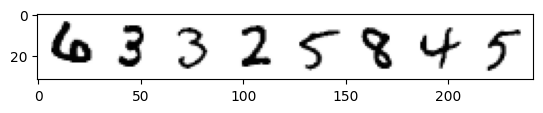

In [2]:
#load mnist 
dataset = torchvision.datasets.MNIST(root="mnist/", train=True, download=True, transform=torchvision.transforms.ToTensor())

#dataloader
train_dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

#view examples
x, y = next(iter(train_dataloader))
print("Shape:", x.shape)
print("Labels:", y)
plt.imshow(torchvision.utils.make_grid(x)[0], cmap="Greys")

In [9]:
# UNetM2DModel with additional input channels

class ClassConditionedUnet(nn.Module):
    def __init__(self, num_classes=10, class_emb_size=4):
        super().__init__()

        #embedding layer will map class label to a vector of size 4
        self.class_emb = nn.Embedding(num_classes, class_emb_size)

        #UNet Architecture
        self.model = UNet2DModel(
            sample_size = 28,
            in_channels = 1 + class_emb_size, #additional channels for class conditioning
            out_channels = 1,
            layers_per_block = 2,
            block_out_channels = (32, 64, 64),

            down_block_types = (
                "DownBlock2D",
                "AttnDownBlock2D",
                "AttnDownBlock2D",
            ),

            up_block_types = (
                "AttnUpBlock2D",
                "AttnUpBlock2D",
                "UpBlock2D",
            ),
        )

    def forward(self, x, t, class_labels):

        #shape
        bs, ch, w, h = x.shape

        #class conditioning
        class_cond = self.class_emb(class_labels) #map to embedding dimension
        class_cond = class_cond.view(bs, class_cond.shape[1], 1, 1).expand(bs, class_cond.shape[1], w, h)
        # x is (bs, 1, 28, 28) class_cond is now (bs, 4, 28, 28)

        #net input is x concatenated with class_cond along dim 1 (channels)
        net_input = torch.cat((x, class_cond), 1)

        return self.model(net_input, t).sample #(bs, 1, 28, 28)

In [10]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule="squaredcos_cap_v2")

In [11]:
#10 epochs training loop
train_dataloader = DataLoader(dataset, batch_size=128, shuffle=True)
n_epochs = 10

net = ClassConditionedUnet().to(device)

loss_fn = nn.MSELoss()
opt = torch.optim.Adam(net.parameters(), lr=1e-3)

#record
losses = []

#training loop
for epoch in range(n_epochs):
    for x, y in tqdm(train_dataloader):

        x = x.to(device) * 2 - 1 #map to (-1, 1)
        y = y.to(device)

        #add noise
        noise = torch.randn_like(x)
        timesteps = torch.randint(0, 999, (x.shape[0],)).long().to(device)
        noisy_x = noise_scheduler.add_noise(x, noise, timesteps)

        pred = net(noisy_x, timesteps, y)

        loss = loss_fn(pred, noise)

        #backprop
        opt.zero_grad()
        loss.backward()
        opt.step()

        losses.append(loss.item())

    avg_loss = sum(losses[-100:]) / 100 #average of last 100 values
    print(f"Finished epoch{epoch}. Average of last 100 values: {avg_loss:05f}")


100%|██████████| 469/469 [02:21<00:00,  3.33it/s]


Finished epocj0. Average of last 100 values: 0.052695


100%|██████████| 469/469 [02:20<00:00,  3.33it/s]


Finished epocj1. Average of last 100 values: 0.046609


100%|██████████| 469/469 [02:21<00:00,  3.33it/s]


Finished epocj2. Average of last 100 values: 0.044054


100%|██████████| 469/469 [02:20<00:00,  3.33it/s]


Finished epocj3. Average of last 100 values: 0.041983


100%|██████████| 469/469 [02:21<00:00,  3.32it/s]


Finished epocj4. Average of last 100 values: 0.040686


100%|██████████| 469/469 [02:21<00:00,  3.31it/s]


Finished epocj5. Average of last 100 values: 0.041058


100%|██████████| 469/469 [02:21<00:00,  3.31it/s]


Finished epocj6. Average of last 100 values: 0.038963


100%|██████████| 469/469 [02:21<00:00,  3.31it/s]


Finished epocj7. Average of last 100 values: 0.039519


100%|██████████| 469/469 [02:22<00:00,  3.30it/s]


Finished epocj8. Average of last 100 values: 0.038390


100%|██████████| 469/469 [02:21<00:00,  3.30it/s]

Finished epocj9. Average of last 100 values: 0.038861


1000it [00:55, 17.98it/s]


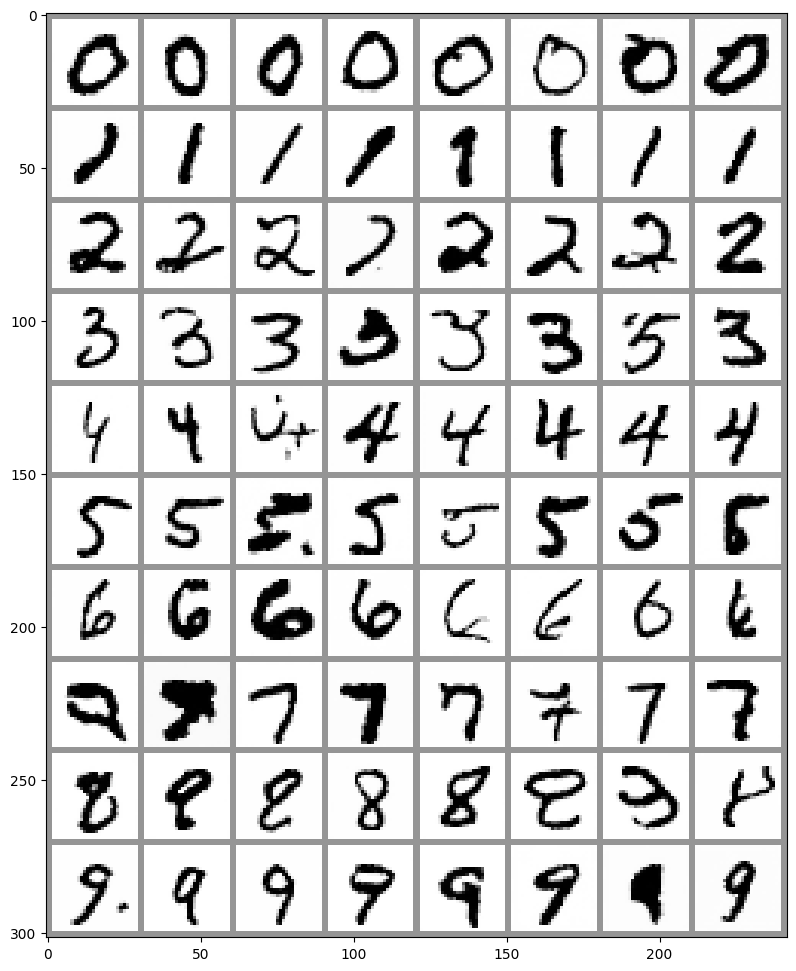

In [12]:
#sampling time
#prep random x and labels y
x = torch.randn(80, 1, 28, 28).to(device)
y = torch.tensor([[i] * 8 for i in range(10)]).flatten().to(device)

#sampling loop
for i, t in tqdm(enumerate(noise_scheduler.timesteps)):

    with torch.no_grad():
        residual = net(x, t, y)
    
    x = noise_scheduler.step(residual, t, x).prev_sample

#show results
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(torchvision.utils.make_grid(x.detach().cpu().clip(-1, 1), nrow=8)[0], cmap="Greys")